# LAB 5-1: Understanding Vision Transformers

<h4><div style="text-align: right"> Due date: 15:00 Nov 25, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab5-1.ipynb]. </div></h4>


### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

In [2]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-20 13:49:22.977829


Package:
PIL                 9.4.0
matplotlib          3.7.1
numpy               1.23.5
session_info        1.0.0
timm                0.9.8
torch               2.1.0+cu118
torchvision         0.16.0+cu118

Refer: Hiroto Honda  [homepage](https://hirotomusiker.github.io/)  

credits:
- 논문: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929
- 모델 구현: this notebook loads (and is inspired by) Ross Wightman (@wightmanr)'s amazing module: https://github.com/rwightman/pytorch-image-models/tree/master/timm . For the detailed codes, please refer to the repo.


# 문제 정의


Vision Transformers(ViT)는 트랜스포머 모델을 이미지 인식에 적용한 혁신적인 접근 방식입니다. 전통적인 합성곱 신경망(CNN)과 달리, ViT는 이미지를 여러 개의 작은 패치로 분할하고, 각 패치를 일종의 단어로 간주하여 트랜스포머 모델에 입력합니다. 이러한 방식은 자연어 처리에서 성공을 거둔 트랜스포머의 강력한 기능을 이미지 처리에 도입하는 것입니다. ViT는 데이터 병렬 처리 능력이 뛰어나고, 긴 거리의 의존성을 효과적으로 학습할 수 있어 높은 성능을 발휘합니다. 특히, 사전 학습된 모델을 활용할 때, 다양한 이미지 데이터셋에서 우수한 성능을 보입니다. ViT는 기존의 CNN 기반 모델들이 갖고 있던 한계를 극복하며, 이미지 인식, 분류, 그리고 다른 시각적 과제들에서 새로운 가능성을 열어주고 있습니다. 이러한 특성 덕분에 ViT는 컴퓨터 비전 분야에서 점점 더 많은 주목을 받고 있습니다.

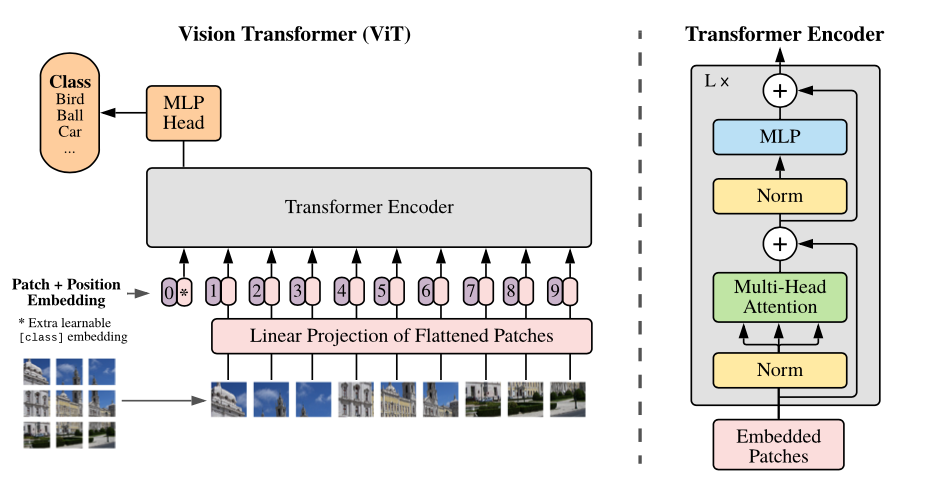

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


기본과제 1번에서는 Vision Transformers(ViT)를 사용하여 이미지 인식 문제를 해결합니다.


사전 학습된 ViT 모델을 로드하여 이미지 분류 작업을 수행해보며 ViT를 이해하는 것이 목적입니다!


## 필요 패키지 import

In [3]:
# %%capture
# !pip install timm

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

/Users/chiyeong/Documents/projects/Deep_Learning_Programming/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # Arrange GPU devices starting from 0 
os.environ["CUDA_VISIBLE_DEVICES"]= "3" # Set the GPU 3 to use

In [6]:
import random
# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seed set to:", seed)

Random seed set to: 0


In [7]:
import sys
import platform

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

if torch.cuda.is_available():
    print("\nGPU information")
    !nvidia-smi
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"\ndevice={device}")
# os.chdir('/home/dlpro24/24-2DLProgramming/huch0')
print(os.getcwd())

Python version
sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)

OS information
macOS-15.0.1-arm64-arm-64bit

Is GPU available?
False

device=mps
/Users/chiyeong/Documents/projects/Deep_Learning_Programming/Labs/Lab5-Vision Transformer



# 모델 선언 및 데이터 로드

In [8]:
model_name = "vit_base_patch16_224"
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# ViT model 생성 : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  mps


In [9]:
# Image transform 선언
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [10]:
%%capture
# ImageNet Labels
# !wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
# !wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

# Vit model 테스트

 사전 학습된 Vision Transformers(ViT) 모델을 사용하여 이미지 분류 작업을 수행하여 ViT가 잘 동작하는지를 확인해볼 수 있습니다.

 주어진 이미지를 모델에 입력한 후, 모델이 예측한 결과를 출력합니다. 예측 결과는 이미지에 대한 분류 라벨로 나타납니다. 이를 통해 모델이 주어진 이미지를 얼마나 정확하게 인식하는지 확인할 수 있습니다.

In [11]:
output = model(img_tensor)

Inference Result:
church, church_building



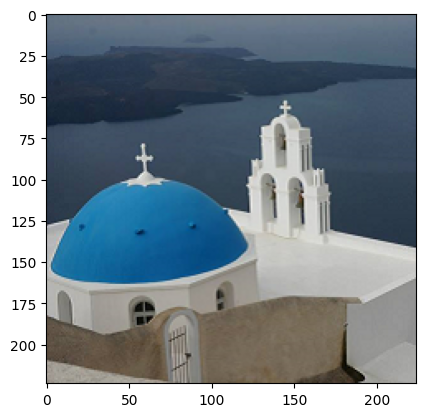

In [12]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Vision Transformer 알아보기

Vision Transformer의 디테일


<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

### Vision Transformer inference 파이프라인

1. 이미지를 패치 단위로 나누기
  - 16x16 kernal size, (16, 16) stride를 가지는 2D convolutional filter를 이용하여 224x224의 이미지를 14x14의 패치로 나누는 단계
2. Position Embedding 더하기
  - 학습가능한 position embedding 벡터를 patch embedding 벡터에 더하고 transformer encoder에 넣는 단계
3. Transformer Encoder
  - Input과 output vector의 dimension은 동일합니다. Encoder의 디테일은 Figure 2에 나타나 있습니다
4. MLP (Classification) Head  
  - Transformer encoder의 output의 첫번째가 MLP head에 입력으로 들어가 final classfication 결과를 얻습니다

# 1. 이미지를 패치로 나누기

입력 이미지를 N개의 패치로 나눕니다. (ViT-base에서 N = 14 x 14)
나눠진 패치는 conv2d를 통해 768의 dimension을 가지는 embedding vector로 변환됩니다.
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [13]:
#############################################################
# TODO: 이미지를 패치 임베딩으로 변환하는 클래스를 정의하세요.
# 이 클래스는 이미지 크기(img_size), 패치 크기(patch_size), 입력 채널 수(in_chans), 임베딩 차원(embed_dim)을 인자로 받습니다.
# 클래스 내부에는 Conv2D 레이어를 사용하여 이미지를 패치 임베딩으로 변환하는 방법을 구현합니다.

# PatchEmbed 클래스를 정의하세요.
# 1. __init__ 메서드에서 인자를 받아 클래스를 초기화합니다.
# 2. 이미지 크기와 패치 크기를 기반으로 그리드 크기와 패치 수를 계산합니다.
# 3. Conv2D 레이어를 사용하여 패치를 임베딩 차원으로 변환하는 레이어를 선언합니다.
# 4. forward 메서드에서는 Conv2D 레이어를 통해 입력 이미지를 변환하고,
#    변환된 텐서를 플래튼(flatten)한 후, transpose를 사용하여 텐서의 차원을 변경합니다.
import torch.nn as nn


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super(PatchEmbed, self).__init__()

        ### Implement Here ###
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2

        self.proj = nn.Conv2d(in_channels=in_chans, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
        ######################

    def forward(self, x):

        ### Implement Here ###
        x = self.proj(x)  # (B, embed_dim, grid_size, grid_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)

        ######################

        return x

#############################################################

In [14]:
my_patch_embed = PatchEmbed().to(device)  # patch embedding convolution
my_patches = my_patch_embed(img_tensor)
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", my_patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


In [15]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


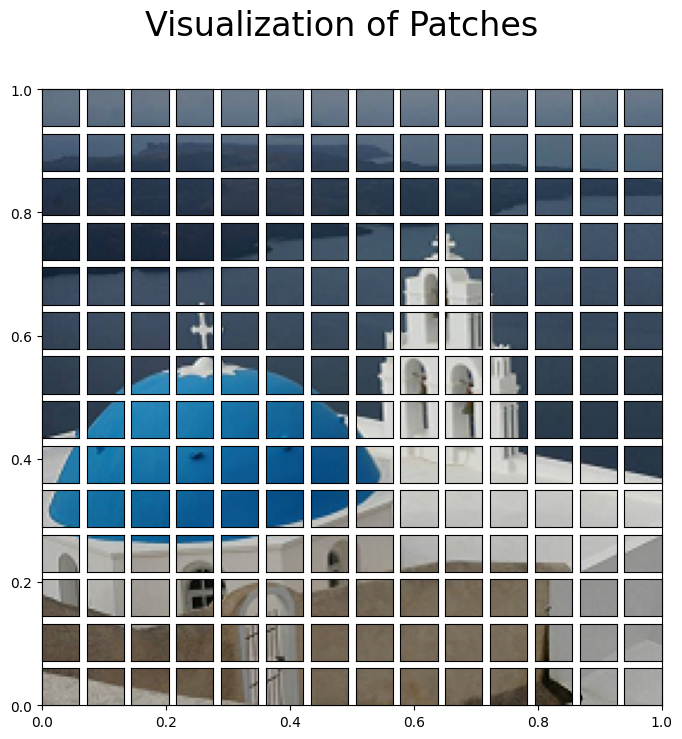

In [16]:
# 패치로 나누어진 image 시각화
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
fig.add_subplot()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# 2. Position Embeddings 더하기
각 패치의 위치를 알려주기 위해, 학습 가능한 position embedding을 Patch embedding vector에 더합니다. position embedding vector는 이미지 내에서 높은 유사성을 보이는 distance를 학습합니다

### Position embeddings 시각화


In [18]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


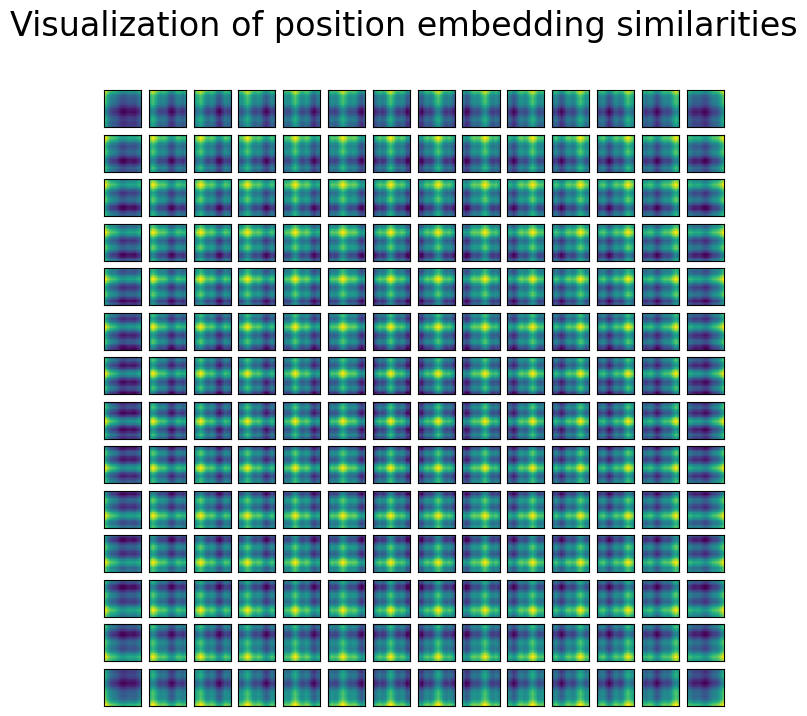

In [32]:
# Position embedding 유사성 시각화
# 하나의 patch와 다른 모든 patch 간의 cosine similarity를 시각화함
cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)  # dime=1 -> dim=2
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    #############################################################
    # TODO: 각 패치와 다른 모든 패치 간의 코사인 유사도를 계산하세요
    # 1. 현재 패치의 임베딩을 선택합니다.
    # 2. 모든 패치의 임베딩을 선택합니다.
    # 3. 두 임베딩 사이의 코사인 유사도를 계산합니다.
    # 4. 유사도 벡터를 원래의 패치 그리드 형태로 재배열합니다.
    # 5. 텐서를 NumPy 배열로 변환하여 CPU에서 처리할 수 있게 합니다.

    # except class token (first patch)
    sim = cos(pos_embed[:, 1:, :], pos_embed[:, i, :].unsqueeze(1))  # (B, num_patches)
    # print(sim.shape)
    sim = sim.reshape(14, 14).detach().cpu().numpy()  # Reshape to 14x14 grid
    # print(sim.shape)

    # .detach().cpu().numpy()

    #############################################################
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Transformer Input 생성
학습가능한 class token이 patch embedding vector의 1번째 순서에 합쳐집니다

A learnable class token is prepended to the patch embedding vectors as the 0th vector.
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [33]:
#############################################################
# TODO: Transformer 모델의 입력을 준비합니다.
# 1. model.cls_token: 클래스 토큰을 가져옵니다. 이는 분류 작업을 위해 추가된 특별한 토큰입니다.
# 2. patches: 이미지 패치 임베딩을 의미합니다. 이는 이미지를 작은 패치로 나누어 임베딩한 결과입니다.
# 3. torch.cat((model.cls_token, patches), dim=1): 클래스 토큰과 패치 임베딩을 결합합니다.
#    이는 클래스 토큰을 패치 임베딩 앞에 추가하여 Transformer 모델의 입력 형식을 만듭니다.
# 4. pos_embed: 위치 임베딩을 가져옵니다. 이는 패치의 위치 정보를 포함하고 있습니다.
# 5. 최종적으로 클래스 토큰과 패치 임베딩을 결합한 것에 위치 임베딩을 더하여 Transformer 입력을 만듭니다.

transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
#############################################################
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

### Transformer Encoder
- N (=197) embedded vector가 L (=12) series로 구성된 transformer encoders에 들어감
- Fully connected layer를 이용해 dimension을 팽창 시킨 후, 해당 벡터를 query (q), key (k), value (v)로 분리함
- Query (q), key (k), value (v)에 parallel attention(=multi-head attention)을 적용하기 위해 H(=12) 개로 분리함
- Attention head를 통과해서 나온 output은 concatenate 되어서 encoder의 input과 동일한 shape를 가지도록 변경함
- Attention head를 적용 한후 Layer norm과 두개의 fc(fully-connected) layer를 통과해서 encoder의 output을 얻음

Vision Transformer는 아래 논문에서 제안된 Transformer의 Encoder를 사용했습니다. [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

Implementation 출처:

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)


### Transformer Encoders 시리즈
트랜스포머에 Input을 통과시키면 L(=12) 번의 encoder를 통과하는 것을 확인할 수 있습니다

In [34]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## Attention의 작동원리

이번 파트에서는 실제로 attention이 어떻게 작동하는지 확인해보겠습니다

In [35]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [36]:
# Input의 dimension을 expand하기 위해 fc layer 적용
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [37]:
# Multi-head attantion을 위해 qkv를 여러개의 q, k, v vector들로 나눕니다.
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


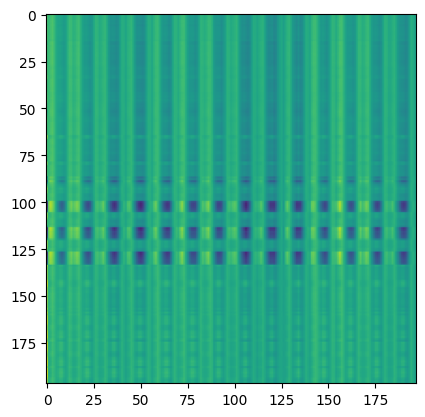

In [ ]:
# Attention Matrix
#############################################################
# TODO: Attention Matrix를 계산하세요
attention_matrix = torch.matmul(q, kT) / np.sqrt(64)
#############################################################
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

### Attention matrix 시각화
이 시각화는 Vision Transformer 모델의 Attention Head들이 이미지의 특정 부분에 어떻게 주목하는지를 보여줍니다. 각 Heatmap은 각 Attention Head의 주목도를 시각적으로 나타내며, 밝은 부분은 높은 주목도를, 어두운 부분은 낮은 주목도를 의미합니다. 이를 통해 모델이 이미지의 다양한 특징에 어떻게 주의를 기울이는지 파악할 수 있습니다. 다양한 Attention Head들이 서로 다른 이미지 패치에 집중하여 전체 이미지를 더 잘 이해하는 데 기여합니다. 이 시각화는 모델의 내부 작동 방식을 이해하는 데 도움이 됩니다.

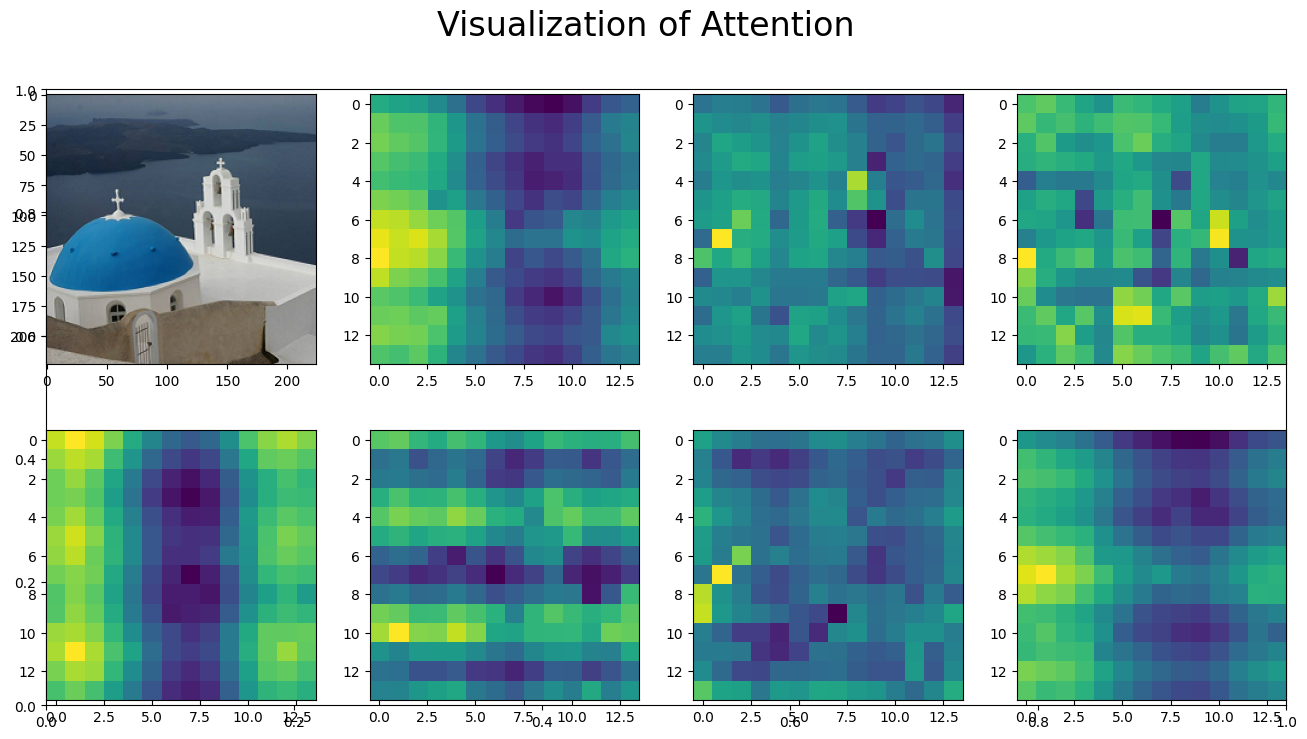

In [45]:
# Attention matrix 시각화
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_subplot()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # 0-7번째 헤드들의 100번째 줄(row)의 attention matrix 시각화
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
Transformer output vector의 0번째값은 class token input에 대응됩니다.
1000-dimension의 classification 결과가 전체 파이프라인의 output입니다


Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 497, label name = church, church_building



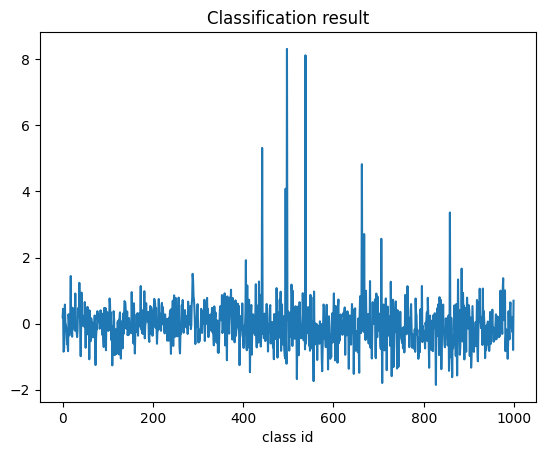

In [46]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

모델은 입력 이미지가 "church, church_building"임을 예측했습니다. 분류 결과는 1000개의 클래스에 대한 신뢰도를 나타내며, 가장 높은 신뢰도를 가지는 클래스 ID는 497입니다. 시각화된 그래프는 각 클래스에 대한 모델의 출력 값을 보여줍니다. 이 결과를 통해 모델이 입력 이미지를 정확히 분류했음을 확인할 수 있습니다.